### Plain custom convolution neural networks for plant disease classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib


In [2]:
def load_data(path):
    filepaths = pathlib.Path(path).glob("**/*.jpg")
    filepaths = list(filepaths)
    filepaths = [str(f) for f in filepaths]
    res = pd.DataFrame()
    res['FilePaths'] = filepaths
    res['Label'] = res['FilePaths'].apply(lambda x: x.split("\\")[-2])
    return res

In [12]:
df_train = load_data('TrainingData')
df_val = load_data('ValidationData')
df_test = load_data("Testing")

### Step 2: Label The data as numeric

In [14]:
def label_data(df):
    labels = list(df['Label'].unique())
    res = {}
    for i,l in enumerate(labels):
        res[l] = i
    #### Now mapping the labels
    df['Label'] = df['Label'].map(res)
    return df


#############################################################################################################
df_train = label_data(df_train)
df_test = label_data(df_test)
df_val = label_data(df_val)

print(df_train.shape,df_test.shape,df_val.shape)

(1322, 2) (150, 2) (60, 2)


### generate data for training

In [162]:
from skimage.transform import rescale,resize
from skimage.io import imread

def scale_image(img,isMinMax = True):
    img = np.float64(img)
    if isMinMax:
        img[:,:,0] = (img[:,:,0] - np.min(img[:,:,0]))/ (np.max(img[:,:,0]) - np.min(img[:,:,0]))
        img[:,:,1] = (img[:,:,1] - np.min(img[:,:,1]))/ (np.max(img[:,:,1]) - np.min(img[:,:,1]))
        img[:,:,2] = (img[:,:,2] - np.min(img[:,:,2]))/ (np.max(img[:,:,2]) - np.min(img[:,:,2]))
    else:
        img[:,:,0] = (img[:,:,0] - np.quantile(img[:,:,0],0.1))/ (np.quantile(img[:,:,0],0.9) - np.quantile(img[:,:,0],0.1))
        img[:,:,1] = (img[:,:,1] - np.quantile(img[:,:,1],0.1))/ (np.quantile(img[:,:,1],0.9) - np.quantile(img[:,:,1],0.1))
        img[:,:,2] = (img[:,:,2] - np.quantile(img[:,:,2],0.1))/ (np.quantile(img[:,:,2],0.9) - np.quantile(img[:,:,2],0.1))
    return img



def num_batches(total,batch_size):
    if total % batch_size == 0:
        return total // batch_size
    else:
        return total // batch_size + 1


def trainer_data_generator(train_df,path_col="FilePaths",label_col='Label',rsize=False,image_shape=(1000,1000,3),batch_size=32,minmax=True):
    total = train_df.shape[0]
    batches = num_batches(total,batch_size)
    train_df = train_df.sample(train_df.shape[0],random_state=10)
    while True:
        for b in range(batches):

            if total % batch_size == 0 or b < batches - 1:
                images = np.zeros((batch_size,image_shape[0],image_shape[1],image_shape[2]))
                labels = np.zeros((batch_size, len(train_df[label_col].unique()) )  )


                ##################### Generating Data If Full Batch Present #######################################
                for i,data in enumerate(train_df.iloc[b*batch_size:b*batch_size+batch_size,:].values):

                    img = imread(data[0])

                    label = data[1]


                    if rsize:
                        img = resize(img,image_shape)
                        img = scale_image(img,True)
                    else:
                        img = scale_image(img,True)
                    images[i,:,:,:] = img
                    labels[i,label] = 1

            else:
                ##################### Generating remaining Data of Last batch #######################################

                bs = total % batch_size

                ### Full Batch not present
                images = np.zeros((bs,image_shape[0],image_shape[1],image_shape[2]))
                labels = np.zeros((bs, len(train_df[label_col].unique()) )  )

                for i,data in enumerate(train_df.iloc[b*batch_size:b*batch_size+bs,:].values):
                    img = imread(data[0])
                    label = data[1]
                    if rsize:
                        img = resize(img,image_shape)
                        img = scale_image(img,True)
                    else:
                        img = scale_image(img,True)
                    images[i,:,:,:] = img
                    labels[i,label] = 1
            #print(data)
            yield images,labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, '90 Precentile and 10 Percentile scaled')

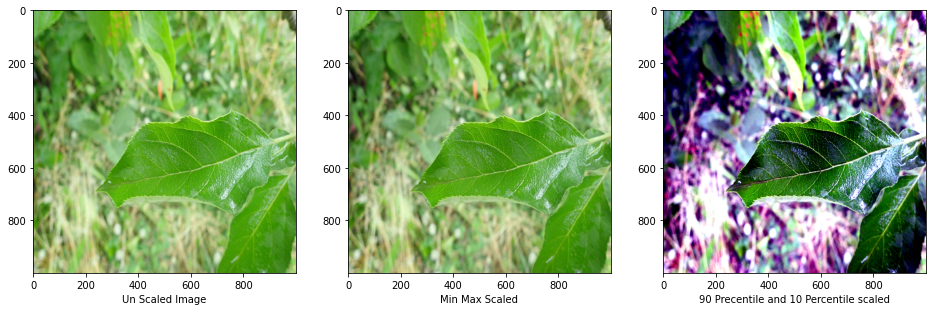

In [232]:
img = imread(df_train.iloc[0,0])
im1 = scale_image(img,True)
im2 = scale_image(img,False)
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(img)
plt.xlabel("Un Scaled Image")
plt.subplot(1,3,2)
plt.imshow(im1)
plt.xlabel("Min Max Scaled")
plt.subplot(1,3,3)
plt.imshow(im2)
plt.xlabel("90 Precentile and 10 Percentile scaled")


### Min Max Scaling will be used as per comparison
- Produces image matrix from 0 to 1 scale
- It does not add noise to data like 90 and 10 %ile scaling

In [164]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout,MaxPool2D,Flatten
#@from tensorflow.keras.

In [165]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(512,512,3)))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))

## Compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 512, 512, 64)      1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 256, 32)      18464     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 524288)           

### Trained it for 10 epochs
- Ran cell 4 times 
- 3 times 3 epochs = 3*3 = 9 epochs
- once 1 epoch = 9 + 1 = 10

### 10 epochs can be run all at once but I did not do because my PC got over heated and took a break of 15 mins after 3 epochs and then again ran the cell

#### In GPU machines you can run all 10 epochs at once

In [219]:
gen = trainer_data_generator(df_train,image_shape=(512, 512, 3),rsize=True)

steps = num_batches(df_train.shape[0],32)
history = model.fit_generator(gen,steps_per_epoch=steps,epochs=1)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


42/42 [==============================] - 773s 18s/step - loss: 0.1214 - accuracy: 0.9652


### Model has overfitted but still good because it gives approx 78 % score

### Evaluation of model

In [220]:
def prepare_validation(df,input_shape=(512,512,3),path='FilePaths',label='Label'):
    #print(df.shape)
    images = np.zeros((df.shape[0],input_shape[0],input_shape[1],input_shape[2]))
    labels = np.zeros((df.shape[0],3))
    x = df[path].tolist()
    y = df[label].tolist()
    for i in range(len(x)):
        image = imread(x[i]) 
        image = resize(image,input_shape)
        image = scale_image(image,isMinMax=True)
        images[i,:,:,:] = image
        labels[i,y[i]] = 1
    return images,labels

In [221]:
img,lbl = prepare_validation(df_val,input_shape=(512,512,3),path='FilePaths',label='Label')

In [222]:
model.evaluate(img,lbl)

2/2 [==============================] - 6s 3s/step - loss: 0.5029 - accuracy: 0.7833


[0.5028746724128723, 0.7833333611488342]

In [226]:
model.save("model.h5")

### 78.33 Accuracy in validation data

In [223]:
input_data,lbl = prepare_validation(df_test,input_shape=(512,512,3),path='FilePaths',label='Label')
predictions = model.predict(input_data)

In [224]:
labels = np.argmax(predictions,axis=1)

<AxesSubplot:>

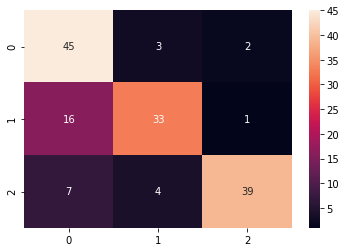

In [228]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf = confusion_matrix(df_test['Label'],labels)
sns.heatmap(cf,annot=True)

### Accuracy score on test data

In [231]:
model.evaluate(input_data,lbl)

5/5 [==============================] - 14s 3s/step - loss: 0.5804 - accuracy: 0.7800


[0.5803526639938354, 0.7799999713897705]

### Conclusion
- Model has 78% Accuracy
- The Score is impacted due to class label 1
- Transfer Learning Model can be used to improve Accuracy